# Calculating "Lyrical Brutality Index" and overall "Total Brutality Index"

A walkthrough, requesting / scraping songtext data from genius.com. Calculating a 'Lyrical Brutality Index' for all Cannibal Corpse songs and combining it with the "Sonic Brutality Index" to the "Total Brutality Index." Revealing the most brutal Cannibal Corpse song of all times. ;-)

_Disclaimer: This notebook contains VERY, VERY EXPLICIT LYRICS._

**Resources**

- [The NRC Valence, Arousal, and Dominance Lexicon](http://saifmohammad.com/WebPages/nrc-vad.html)
- [Blogpost on scraping song lyrics](https://chrishyland.github.io/scraping-from-genius/) - Thanks to Chris Hyland for this!
- [Genius API documentation](https://docs.genius.com/#/getting-started-h1) 


**Data Input:**

- `data/interim/audio_data.csv`: DataFrame of all CC tracks with "Sonic Brutality Index" (from notebook 1)
- `data/raw/NRC-VAD-Lexicon.txt`: Data of approx 20'000 words with valence, arousal and dominance scores

**Data Output:**

- `data/processed/wbi_lexicon.csv`: DataFrame containing 20'000 words with their corresponding 'Word Brutality Index"
- `data/processed/final_CC_song_data.csv`: Final DataFrame of all CC tracks complete with TBI, sbi, lbi

**Changes**

- 2019-02-27: Start notebook
- 20-02-29: Complete analysis

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Load-and-Prepare-Lexicon" data-toc-modified-id="Load-and-Prepare-Lexicon-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and Prepare Lexicon</a></span></li><li><span><a href="#Scrape-and-Prepare-Lyrics" data-toc-modified-id="Scrape-and-Prepare-Lyrics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scrape and Prepare Lyrics</a></span></li><li><span><a href='#Define-and-calculate-the-"Lyrical-Brutality-Index"' data-toc-modified-id='Define-and-calculate-the-"Lyrical-Brutality-Index"-4'><span class="toc-item-num">4&nbsp;&nbsp;</span>Define and calculate the "Lyrical Brutality Index"</a></span></li><li><span><a href="#Bring-it-all-together:-Calculate-'Total-Brutality-Index'" data-toc-modified-id="Bring-it-all-together:-Calculate-'Total-Brutality-Index'-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bring it all together: Calculate 'Total Brutality Index'</a></span><ul class="toc-item"><li><span><a href="#Normalize-LBI-and-SBI" data-toc-modified-id="Normalize-LBI-and-SBI-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Normalize LBI and SBI</a></span></li><li><span><a href="#Calculate-TBI" data-toc-modified-id="Calculate-TBI-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Calculate TBI</a></span></li></ul></li><li><span><a href="#Appendix:-The-big-question---Barnes-or-Corpsegrinder?" data-toc-modified-id="Appendix:-The-big-question---Barnes-or-Corpsegrinder?-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Appendix: The big question - Barnes or Corpsegrinder?</a></span></li><li><span><a href="#For-documentation-only:-Test-Alternative-LBI-Definitions" data-toc-modified-id="For-documentation-only:-Test-Alternative-LBI-Definitions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>For documentation only: Test Alternative LBI Definitions</a></span></li></ul></div>

---

## Import libraries

In [1]:
# Import libraries

from pprint import pprint
import pickle
import re
import requests
import urllib.request
import urllib.parse
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.preprocessing import minmax_scale
import credentials # file where credentials for genius API are stored

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer  # default lemmatizer

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('raph-base')
import seaborn as sns 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\r2d4\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load and Prepare Lexicon
In this section we prepare a lexicon containing a 'word brutality index' for more than 20'000 words.

It will be based on "The NRC Valence, Arousal, and Dominance (VAD) Lexicon", which includes a list of more than 20,000 English words and their valence, arousal, and dominance scores. For a given word and a dimension (V/A/D), the scores range from 0 (lowest V/A/D) to 1 (highest V/A/D). 

- valence is the positive--negative or pleasure--displeasure dimension; 
- arousal is the excited--calm or active--passive dimension; and 
- dominance is the powerful--weak or 'have full control'--'have no control' dimension. 


Reading the VAD-lexicon into a Pandas DataFrame requires a little tweaking / cleaning, because the first columns seem a bit messed up.

In [2]:
with open('data/raw/NRC-VAD-Lexicon.txt') as file:
    data_list = []
    line = file.readline()
    while line:
        data_list.append(str(line))
        line = file.readline()

In [3]:
# Check results
data_list[:5]

['Word\tValence\tArousal\tDominance\n',
 'aaaaaaah\t0.479\t0.606\t0.291\n',
 'aaaah\t0.520\t0.636\t0.282\n',
 'aardvark\t0.427\t0.490\t0.437\n',
 'aback\t0.385\t0.407\t0.288\n']

In [4]:
# Split and clean
data_list2 = [x.replace('\n', '').split('\t') for x in data_list]

In [5]:
vad_lexicon = pd.DataFrame(data_list2[1:], columns=data_list2[0], dtype=float)
vad_lexicon.columns = (col.lower() for col in vad_lexicon.columns)

In [6]:
# Check results ...
display(vad_lexicon.iloc[[1860]])

,word,valence,arousal,dominance
1860,bloodshed,0.048,0.942,0.525


Exactly what we are looking for: low valence, high arousal ... ;-) 

We can also see that `dominance` is quite neutral and probably no feature that will be of further help. To more easily filter and analize for words with a combination of low-valence and high-arousal I will create a new feature `anti-valence` that is (1 - valance). Then we can simply sum the 2 scores to get a `word brutality index (WBI)`. (To land in a range between 0 and 1 we will normalize it using sklearn's minmax_scaler.)

_Note to myself: If I would like to compare with the results of other artists, I would have skip the scaling and calculate the wbi with: (a_v + a) / 2

In [7]:
lexicon = vad_lexicon.copy()
lexicon['anti_valence'] = lexicon['valence'].apply(lambda x: 1-x)
wbi = minmax_scale(lexicon['anti_valence'] + lexicon['arousal'])
lexicon['wbi'] = wbi
lexicon.drop(['valence', 'dominance'], axis=1, inplace=True)
lexicon = lexicon.sort_values(['wbi'], ascending=False).reset_index(drop=True)

In [8]:
# Check results ...
display(lexicon.nlargest(10, 'wbi'))
display(lexicon.loc[lexicon['word'] == 'zombie'])

,word,arousal,anti_valence,wbi
0,homicide,0.973,0.990,1.000000
1,murderer,0.960,0.990,0.992746
2,killer,0.971,0.959,0.981585
3,abduction,0.990,0.938,0.980469
4,suicidebombing,0.957,0.969,0.979353
5,murderous,0.940,0.983,0.977679
6,dangerous,0.941,0.980,0.976562
7,assassinate,0.969,0.949,0.974888
8,aggresive,0.971,0.941,0.971540
9,terrorist,0.930,0.981,0.970982


,word,arousal,anti_valence,wbi
2250,zombie,0.648,0.786,0.704799


Wow, people nowadays definitely seem to be scared a lot more of suicide bombers than of zombies ... how come?

In [9]:
# Save a copy of the lexicon
lexicon.to_csv('data/processed/wbi_lexicon_cc.csv', index=False)

In [10]:
# Visualize distribution of 'wbi'

def show_wbi_distribution(data, percentiles=[95]):
    """Show the value distribution of a list of WBI-scores, with percentiles."""
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(data, color='rebeccapurple', bins=30, hist_kws={'edgecolor': 'white'})
    for percentile in percentiles:
        qvl = plt.axvline(np.percentile(data, percentile) , color='grey', linewidth=2.0)
    ax.legend([qvl], [f'Percentiles {percentiles}'], fontsize=10)
    ax.set_title('Overall WBI Distribution for Lexicon', fontsize=12)
    ax.set_xlabel('Word Brutality Index', fontsize='large')
    ax.set_ylabel('Frequency', fontsize='large');

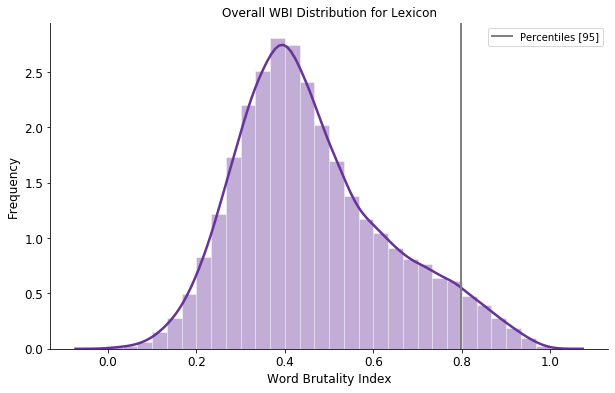

In [11]:
show_wbi_distribution(lexicon['wbi'])

Let's say that the top 10% of WBI scores are the 'brutal' words. This will be the threshold we will use when calculating the "Lyrical Brutality Index" later on. All words with a wbi score higher than that will be considered 'brutal'. The threshold's value is:

In [12]:
wbi_threshold = np.percentile(lexicon['wbi'], 95)
print("WBI-threshold for 'brutal' words:", round(wbi_threshold, 3))

WBI-threshold for 'brutal' words: 0.797


In [13]:
# Look at some words around threshold

print("Just above threshold:")
display(lexicon.loc[lexicon['wbi'] >= 0.797].tail())
print("\nJust below threshold:")
display(lexicon.loc[lexicon['wbi'] < 0.797].head())


Just above threshold:


,word,arousal,anti_valence,wbi
1002,chagrin,0.704,0.896,0.797433
1003,harlot,0.798,0.802,0.797433
1004,counterfeit,0.694,0.906,0.797433
1005,obsessing,0.773,0.827,0.797433
1006,indecent,0.683,0.917,0.797433



Just below threshold:


,word,arousal,anti_valence,wbi
1007,filthy,0.714,0.885,0.796875
1008,appalled,0.792,0.806,0.796317
1009,bastards,0.680,0.918,0.796317
1010,pornography,0.921,0.677,0.796317
1011,warship,0.890,0.708,0.796317


Does this threshold make sense? Hard to say. But I played around with different thresholds in the range from 20% to 5% and the final rankings don't change much.

In [14]:
# Create a lookup dictionary for 'word: wbi' - we'll use it later
wbi_lookup = dict(zip(lexicon['word'], lexicon['wbi']))
print(list(wbi_lookup.items())[:5])

[('homicide', 0.9999999999999999), ('murderer', 0.9927455357142855), ('killer', 0.9815848214285713), ('abduction', 0.9804687499999999), ('suicidebombing', 0.9793526785714285)]


## Scrape and Prepare Lyrics

Scrape all Cannibal Corpse lyrics from the genius API.

In [15]:
base = "https://api.genius.com"
genius_token = credentials.genius_token

def get_json(path, params=None, headers=None):
    '''Send request and get response in json format.'''

    # Generate request URL
    requrl = '/'.join([base, path])
    token = f"Bearer {genius_token}"
    if headers:
        headers['Authorization'] = token
    else:
        headers = {"Authorization": token}
    # Get response object from querying genius api
    response = requests.get(url=requrl, params=params, headers=headers)
    response.raise_for_status()
    return response.json()

In [16]:
# Get artist ID based on artist name

name = "Cannibal Corpse"

def get_artist_id(artist_name):
    '''Search Genius API for artist ID via artist name.'''

    search = "/search?q="
    query = base + search + urllib.parse.quote(artist_name)
    request = urllib.request.Request(query)
    request.add_header("Authorization", "Bearer " + genius_token)
#     request.add_header("User-Agent", "")  
    response = urllib.request.urlopen(request, timeout=3)
    raw = response.read()
    data = json.loads(raw)['response']['hits']
    
    return (data[0]['result']['primary_artist']['id'])

In [17]:
artist_id = get_artist_id(name)
print(artist_id)

41863


In [18]:
def get_songlist(artist_id):
    '''Get all the song ids and titles from an artist in form of a dict.'''
    current_page = 1
    next_page = True
    songs = [] # to store final song ids
    while next_page:
        path = f"artists/{artist_id}/songs/"
        params = {'page': current_page} # the current page
        data = get_json(path=path, params=params) # get json of songs
        page_songs = data['response']['songs']
        if page_songs:
            # Add all the songs of current page
            songs += page_songs
            # Increment current_page value for next loop
            current_page += 1
            print(f"Page {current_page} finished scraping")
            # If you don't wanna wait too long to scrape, un-comment this
            # if current_page == 2:
            #     break
        else:
            # If page_songs is empty, quit
            next_page = False

    print(f"Song id were scraped from {current_page} pages")

    # Get all the song ids, excluding not-primary-artist songs.
    songlist = {song["id"]: song['title'].lower() for song in songs
                if song["primary_artist"]["id"] == artist_id}

    return songlist

In [19]:
songlist = get_songlist(artist_id)
print(f"\n{list(songlist.items())[:2]}")
print("# of songs:", len(songlist))

Page 2 finished scraping
Page 3 finished scraping
Page 4 finished scraping
Page 5 finished scraping
Page 6 finished scraping
Page 7 finished scraping
Page 8 finished scraping
Page 9 finished scraping
Page 10 finished scraping
Page 11 finished scraping
Song id were scraped from 11 pages

[(764037, 'absolute hatred'), (715726, 'a cauldron of hate')]
# of songs: 187


In [20]:
# Remove songs from live albums (they are duplicates from a lyrical perspective)
songlist = {id_: title for id_, title in songlist.items() if "live" not in title}
print("# of songs (excluding live performances):", len(songlist))

# of songs (excluding live performances): 174


In [21]:
def connect_lyrics(song_id):
    '''Constructs the path of song lyrics. (Called within next function.)'''

    url = f"songs/{song_id}"
    data = get_json(url)
    # Gets the path of song lyrics
    path = data['response']['song']['path']
    return path

def retrieve_lyrics(song_id):
    '''Retrieves lyrics from html page. (Again, called within next function.)'''

    path = connect_lyrics(song_id)
    URL = "http://genius.com" + path
    page = requests.get(URL)
    # Extract the page's HTML as a string
    html = BeautifulSoup(page.text, "html.parser")
    # Scrape the song lyrics from the HTML
    lyrics = html.find("div", class_="lyrics").get_text()
    return lyrics

def scrape_lyrics(songlist):
    """Scrape the lyrics from the songs in a songlist."""
    lyrics_dict = {}
    for song_id, title in tqdm(songlist.items()):
        lyrics_dict[title] = retrieve_lyrics(song_id)  
    return lyrics_dict

In [22]:
lyrics_dict = scrape_lyrics(songlist)

100%|██████████| 174/174 [08:16<00:00,  2.85s/it]


In [24]:
# Save / load dict
# with open('data/interim/lyrics_dict.pkl', 'wb') as f:
#         pickle.dump(lyrics_dict, f, pickle.HIGHEST_PROTOCOL)
with open('data/interim/lyrics_dict.pkl', 'rb') as f:
    lyrics_dict = pickle.load(f)

In [25]:
# Print sample
lyrics_dict['absolute hatred']

"\n\nNever leave your nest unguarded\nNext of kin the first to go\nAbsolute hatred cast upon the family\nPayback for the hated one\n\nI am the judge, jury, executioner\nAnd pallbearer all in one\nProcess of elimination\nAffirmative action has just begun\nExpectorate upon your soul\nMalicious devilry is unleashed ten fold\nYou cannot hide\n\nWitness of my stopping power\nReaction time is not enough\nPsychological torment tearing at you sanity\nIt has to be, it must be done\n\nHatred flows, uncontained, feel my wrath\nThrough the death of your entire tribe\n\nHatred flows, uncontained\nI must achieve my revenge through hatred\n\nI've regained my pride\nVictory's mine\nYou cannot hide\nThe footsteps you hear are gonna be mine\n\n"

In [26]:
def process_text(raw_text):
    """A simple NLP pipeline returning 'lemmed' tokens."""
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    text = re.sub(r"[^a-zA-Z0-9]", " ", raw_text.lower().strip())
    tokens = word_tokenize(text)
    lemmed = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    lemmed_tokens = [WordNetLemmatizer().lemmatize(w, pos='v') for w in lemmed]  # lemm to verbs, not nouns 
    return lemmed_tokens

Note: The lemmatization has a certain effect on the results as for example the word "torture" (V: 0.115, D: 0.878) has not exactly the same values as the word "tortured" (V: 0.062, D: 0.890). But the differences are fairly small and so I will just go on. (I also have destroyed all word combinations / context, there are typos, ... NLP is a tricky field ...)

In [27]:
lyrics_dict_clean = {title: process_text(lyric) for title, lyric in lyrics_dict.items()}
# print one sample
print(lyrics_dict_clean['absolute hatred'])

['never', 'leave', 'nest', 'unguarded', 'next', 'kin', 'first', 'go', 'absolute', 'hatred', 'cast', 'upon', 'family', 'payback', 'hat', 'one', 'judge', 'jury', 'executioner', 'pallbearer', 'one', 'process', 'elimination', 'affirmative', 'action', 'begin', 'expectorate', 'upon', 'soul', 'malicious', 'devilry', 'unleash', 'ten', 'fold', 'hide', 'witness', 'stop', 'power', 'reaction', 'time', 'enough', 'psychological', 'torment', 'tear', 'sanity', 'must', 'do', 'hatred', 'flow', 'uncontained', 'feel', 'wrath', 'death', 'entire', 'tribe', 'hatred', 'flow', 'uncontained', 'must', 'achieve', 'revenge', 'hatred', 'regain', 'pride', 'victory', 'mine', 'hide', 'footstep', 'hear', 'gon', 'na', 'mine']


In [28]:
lyrics_dict_wbi = {}
for title, text in lyrics_dict_clean.items():
    lyrics_dict_wbi[title] = [wbi_lookup[word] for word in text if word in wbi_lookup.keys()]

In [29]:
# print one sample
print(lyrics_dict_wbi['absolute hatred'])

[0.4291294642857142, 0.20256696428571425, 0.6981026785714285, 0.4056919642857142, 0.3928571428571428, 0.4241071428571428, 0.4536830357142857, 0.9146205357142857, 0.4972098214285713, 0.1361607142857143, 0.4854910714285713, 0.2276785714285714, 0.32310267857142855, 0.5150669642857142, 0.5340401785714286, 0.786830357142857, 0.32310267857142855, 0.4408482142857142, 0.8058035714285713, 0.31473214285714285, 0.5396205357142856, 0.4023437499999999, 0.15569196428571425, 0.7907366071428571, 0.6277901785714285, 0.2940848214285714, 0.4776785714285713, 0.5027901785714286, 0.466517857142857, 0.5909598214285714, 0.4352678571428571, 0.6529017857142857, 0.2862723214285714, 0.4866071428571428, 0.8493303571428571, 0.5831473214285714, 0.2762276785714285, 0.4481026785714286, 0.39453124999999994, 0.9146205357142857, 0.25055803571428575, 0.35100446428571425, 0.9475446428571427, 0.8470982142857142, 0.33593750000000006, 0.36328124999999994, 0.9146205357142857, 0.25055803571428575, 0.4481026785714286, 0.31138392

In [30]:
# Just for visualization, display as boolean
show = list(lyrics_dict_wbi['absolute hatred'] )
show = ['BRUTAL' if x > wbi_threshold else 'False' for x in show]
print(show)

['False', 'False', 'False', 'False', 'False', 'False', 'False', 'BRUTAL', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'BRUTAL', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'BRUTAL', 'False', 'False', 'False', 'False', 'BRUTAL', 'False', 'False', 'BRUTAL', 'BRUTAL', 'False', 'False', 'BRUTAL', 'False', 'False', 'False', 'BRUTAL', 'BRUTAL', 'False', 'False', 'False', 'False', 'False', 'False', 'False']


## Define and calculate the "Lyrical Brutality Index"

I was looking for an score that takes into account how many 'brutal' words are used in a song, what the proportion of these is in relation to the total of the words sung (screamed / growled) and relates them to the duration of a song. So that's what I chose in the end:

$$Lyrical Brutality Index = \sqrt{(\frac{\text{brutal words}} {\text{number of words}}) * (\frac{\text{number of words}}{\text{duration}})}  $$

$$Lyrical Brutality Index =  \sqrt{\frac{\text{brutal words}} {\text{duration}}}$$

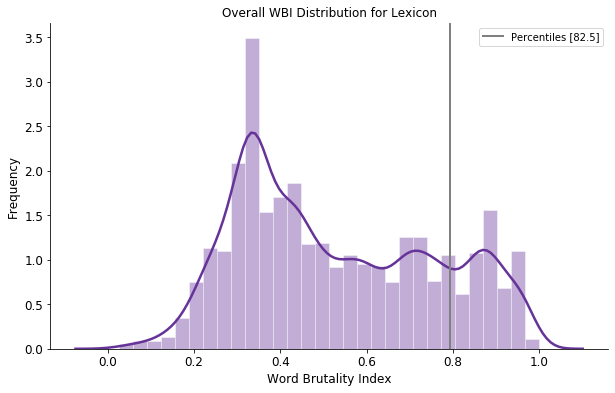

In [31]:
# Visualize the distribution of wbi scores over the whole CC text corpus (ignore graph titel)
full_corpus = [score for text in lyrics_dict_wbi.values() for score in text]
show_wbi_distribution(full_corpus, percentiles=[82.5])  # approx the threshold value for brutal words

In [32]:
def calculate_lb_features(text, wbi_treshold=wbi_threshold):
    """Calculate and return features needed to calculate the lbi."""
    total_words = len(text)
    brutal_words = np.sum(text > wbi_threshold)
    brutal_prop = brutal_words / total_words
    
    return total_words, brutal_words, brutal_prop

In [33]:
# Create a Dataframe with the lb features
lb_features_dict = {title: calculate_lb_features(text) for title, text in lyrics_dict_wbi.items()}
print(list(lb_features_dict.items())[:2])

[('absolute hatred', (59, 9, 0.15254237288135594)), ('a cauldron of hate', (132, 41, 0.3106060606060606))]


In [34]:
lyric_data = pd.DataFrame(lb_features_dict.keys(), columns=['title'])
lyric_data['total_words'] = lyric_data['title'].apply(lambda x: lb_features_dict[x][0])
lyric_data['brutal_words'] = lyric_data['title'].apply(lambda x: lb_features_dict[x][1])
lyric_data['brutal_prop'] = lyric_data['title'].apply(lambda x: lb_features_dict[x][2])
display(lyric_data.sort_values(['brutal_prop'], ascending=False).head())

,title,total_words,brutal_words,brutal_prop
41,demented aggression,109,53,0.486239
60,firestorm vengeance,89,40,0.449438
69,grotesque,76,33,0.434211
162,torn through,147,59,0.401361
35,crucifier avenged,176,69,0.392045


In [35]:
# Look at lyrics with highest proportion of 'brutal' words
lyrics_dict['demented aggression']

"\n\nPain is my reward from psychotic tendencies\nPain I give to you\nPain relentlessly\nTorturing has reached a level no one's ever seen\nSuffer for your life\nRabid force extreme\nRage is my obsession driven by my cruelty\nRage is my release\nRage relentlessly\nRavaging continues through my scattered lunacy\nMalice for your life\nRapid force extreme\n\nDemented aggression\n\nHate is the reason I embrace these fantasies\nHate engulfs my mind\nHate relentlessly\nWith pain and rage and hatred relentlessly\n\nWith pain\nRage and hate\nBeatings come faster\nBeatings last longer\nWith pain\nRage and hate\nBeatings are forever\nI don't think you'll live\n\nDon't think you'll live\nDon't think you'll live\nI don't think you'll live\n\nPain is my reward from psychotic tendencies\nRage is my release\nHate relentlessly\nWith pain and rage and hatred relentlessly\n\nWith pain\nRage and hate\nTorture coming faster\nTorture lasting longer\nWith pain\nRage and hate\nTorture is forever\nI don't thin

Ok ... nearly 50% of words are classified as 'brutal', but that's not yet what we really want. The relation to the song's duration (the 'lyrical density') is still missing.

In [37]:
# Load the audio data DataFrame to merge it with the lyric data
audio_data = pd.read_csv('data/interim/audio_data.csv')
audio_data['title'] = audio_data['title'].str.lower()
audio_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 9 columns):
title           164 non-null object
album           164 non-null object
year            164 non-null int64
uri             164 non-null object
energy          164 non-null float64
valence         164 non-null float64
danceability    164 non-null float64
sbi             164 non-null float64
duration_sec    164 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 11.7+ KB


There are some differences (typos etc.) in the writing of song titles in the two dataframes. Let's clean them before the merge.

In [38]:
to_replace = {'caged... contorted': 'caged...contorted', 'coffinfeeder': 'coffin feeder', 'ecstacy in decay': 'ecstasy in decay', 
'entrails ripped from a virgin’s cunt': "entrails ripped from a virgin's cunt", 'meat hook sodomy':  'meathook sodomy',
'pulverised': 'pulverized', 'scattered remains, splattered brains': 'scattered remains splattered brains', 
'stripped, raped and strangled': 'stripped, raped, and strangled', 'the exorcist': 'the exorcist (bonus track)',
'the murderer’s pact': "the murderer's pact", 'the pick-axe murders': 'the pick axe murders'}

for x, y in to_replace.items():
    lyric_data['title'].replace(x, y, inplace=True)

In [39]:
song_data = pd.merge(audio_data, lyric_data, on='title', how='inner')
song_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 160
Data columns (total 12 columns):
title           161 non-null object
album           161 non-null object
year            161 non-null int64
uri             161 non-null object
energy          161 non-null float64
valence         161 non-null float64
danceability    161 non-null float64
sbi             161 non-null float64
duration_sec    161 non-null float64
total_words     161 non-null int64
brutal_words    161 non-null int64
brutal_prop     161 non-null float64
dtypes: float64(6), int64(3), object(3)
memory usage: 16.4+ KB


After merging the audio and lyrics data we have 161 songs remaining with data for both. None of the ones that could not be matched with the audio data had a particularly high sbi. And only a very few of the ones lost had reasonably high proportion of brutal words. So that's ok.

In [40]:
# Finally calculate the lbi
song_data['lbi'] = song_data['brutal_words'] / song_data['duration_sec']
song_data['title'] = song_data['title'].str.title()  # looks better
display(song_data[['title', 'brutal_words', 'duration_sec', 'lbi']].nlargest(5, 'lbi'))

,title,brutal_words,duration_sec,lbi
106,Puncture Wound Massacre,41,101.200,0.405138
153,Torn Through,59,191.386,0.308278
33,Crucifier Avenged,69,226.333,0.304861
39,Demented Aggression,53,194.466,0.272541
45,Dormant Bodies Bursting,30,120.333,0.249308


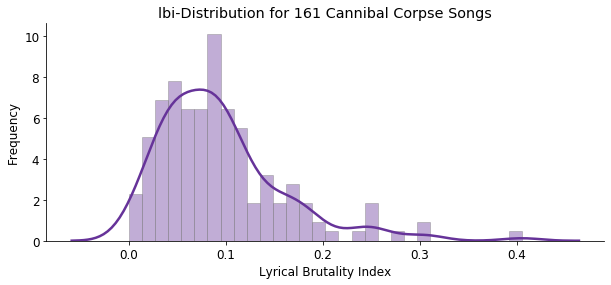

In [41]:
# Visualize distribution of lbi
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(song_data['lbi'], color='rebeccapurple', bins=30, 
             label='Lyrical Brutality Index', hist_kws={'edgecolor': 'grey'})
ax.set_title("lbi-Distribution for 161 Cannibal Corpse Songs", size='x-large')
ax.set_xlabel("Lyrical Brutality Index", size='large')
ax.set_ylabel("Frequency", size='large');

Wow ... one massive outlier here ... "Puncture Wound Massacre" is by far the song with the highest "Lyrical Brutality Index" score. This is surely aided by the songs short duration of only 1:41 min. Altough the proportion of brutal words is not particularly high, Cannibal Corpse have managed to pack a lot of text (see total number of words) into that short time span. No time for rest ... And the text IS disgustingly brutal.

In [42]:
print(lyrics_dict['puncture wound massacre'])



Stab, hack, slash, kill
Stab, hack, slash, kill
Stab, hack, slash, kill
Stab, hack, slash, kill
Die, butcher
Rage of hate
Stab, hack, slash, kill
Stab, hack, slash, kill
Stab, hack, slash, kill
Stab, hack, slash, kill

Kick down the door in barbaric rage
Frantically slashing all who stand in my way
Stab another face, slit another throat
My intention is to mutilate them
People are screaming it feeds my hate
Hack through the crowd blood is splashing on my face
I only see red, rage exploding
Two knives, one mind, that hate has broken

Stabbing, disfigure, knives puncture
Blood gushing from their wounds
Rivers run deep red
Down faces of people in the room
Bodies are heaping they're dying
In seconds they were slain
Daggers in my hands are killing
This worthless piece of shit

Hate for them still drives my rage
My job is almost finished only one remains
In the corner terrified behind the grisly slaughter
Ill take my time on this last scum bag
Knife in stomach, hes not dead yet
Carving up h

## Bring it all together: Calculate 'Total Brutality Index'

### Normalize LBI and SBI

For the final step I will each normalize the SBI (Sonic Brutality Index) and the LBI so that they are in the same range.

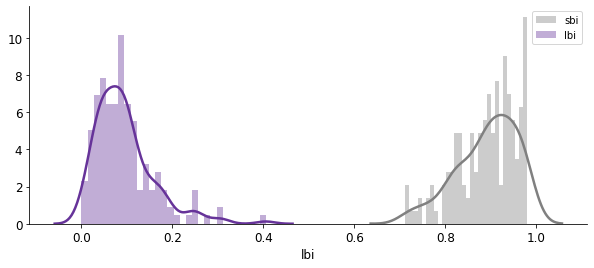

In [43]:
# Visualize distribution of lbi and sbi BEFORE normalization
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(song_data['sbi'], color='grey', bins=30, label='sbi')
sns.distplot(song_data['lbi'], color='rebeccapurple', bins=30, label='lbi');
ax.legend();

In [44]:
song_data['lbi'] = minmax_scale(song_data['lbi'])
song_data['sbi'] = minmax_scale(song_data['sbi'])

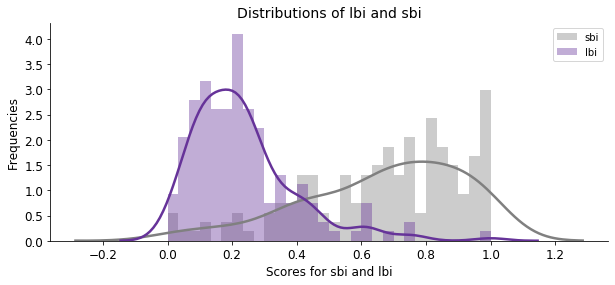

In [45]:
# Visualize distribution of lbi and sbi AFTER normalization
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(song_data['sbi'], color='grey', bins=30, label='sbi')
sns.distplot(song_data['lbi'], color='rebeccapurple', bins=30, label='lbi');
ax.set_xlabel("Scores for sbi and lbi")
ax.set_ylabel("Frequencies")
ax.set_title("Distributions of lbi and sbi",size=14)
ax.legend();

### Calculate TBI

Let's simply take the average (arithmetic mean) of the two indexes. Since both indexes are on the same scale (they both range from 0 to 1), this would imply that the amount of brutality  in a song’s lyrics and a song’s sound equally determine the level of overall brutality in that song. (In this case tough the SBI has somewhat higher scores and is favoured a little bit.)

$$Total Brutality Index = (0.5 * Sonic Brutality Index) + (0.5 * Lyrical Brutality Index)$$

In [46]:
song_data['TBI'] = (song_data['sbi'] * 0.5) + (song_data['lbi'] * 0.5)

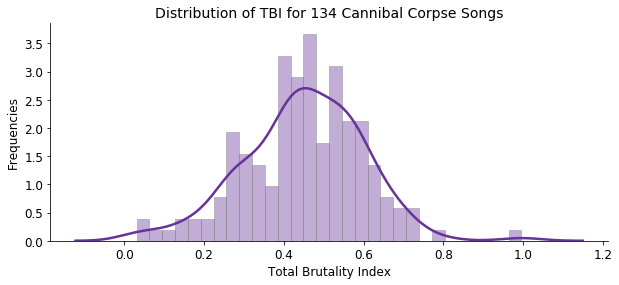

In [47]:
# Visualize distribution of the TBI
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(song_data['TBI'], color='rebeccapurple', bins=30, label='TBI', hist_kws={'edgecolor': 'grey'})
ax.set_xlabel("Total Brutality Index")
ax.set_ylabel("Frequencies")
ax.set_title("Distribution of TBI for 134 Cannibal Corpse Songs",size=14);

In [48]:
# Display the most brutal songs
song_data[['title', 'sbi', 'lbi', 'TBI']].nlargest(5, 'TBI')

,title,sbi,lbi,TBI
106,Puncture Wound Massacre,0.991416,1.000000,0.995708
45,Dormant Bodies Bursting,0.961187,0.615366,0.788276
102,Pounded Into Dust,0.822915,0.614246,0.718580
153,Torn Through,0.656839,0.760919,0.708879
121,Savage Butchery,0.811719,0.600975,0.706347


It was evident from the last section that 'Puncture Wound Massacre' would score the top slot. And it does so by a wide margin. (That there would be such a clear winner was not really to be expected, but is result of the chosen index scores.) - THAT'S IT.

In [49]:
# Display the least brutal songs - the latter two are instrumentals!
song_data.nsmallest(3, 'TBI')

,title,album,year,uri,energy,valence,danceability,sbi,duration_sec,total_words,brutal_words,brutal_prop,lbi,TBI
85,Living Dissection,Butchered At Birth,1991,spotify:track:0IAIQhIMw8ehSQdR2Nxlab,0.989,0.565,0.292,0.000000,238.440,161,6,0.037267,0.062111,0.031056
61,From Skin To Liquid,Gallery of Suicide,1998,spotify:track:4kYLhsdj7PkuxcZlWuZMop,0.798,0.334,0.109,0.074641,330.266,1,0,0.000000,0.000000,0.037320
113,Relentless Beating,Vile,1996,spotify:track:0ox3y11lj7cGdgS1uAsW02,0.988,0.493,0.176,0.132487,134.506,1,0,0.000000,0.000000,0.066244


In [50]:
# Save data
song_data.to_csv('data/processed/final_CC_song_data.csv', index=False)

---

## Appendix: The big question - Barnes or Corpsegrinder?
The history of Cannibal Corpse can largely be split into two areas: The iconic four first albums with original singer Chris Barnes and all the rest with the singer George 'Corpsegrinder' Fisher (since 1995). They both have different styles but were equally successful with Cannibal Corpse. Nevertheless, the discussion if the 'original' or the 'new' Cannibal Corpse are the better version of the group remains one of the hottest topics when fans are discussing about the band.

I cannot say who is better, but at least we can check who was / is more brutal:

In [51]:
# Load data
song_data = pd.read_csv('data/processed/final_CC_song_data.csv')
print(song_data.shape)

In [118]:
# Create new col that maps songs to singers

barnes_albums = ['Eaten Back To Life', 'Butchered At Birth', 'Tomb Of The Mutilated', 'The Bleeding']

def check_singer(x):
    if x in barnes_albums:
        return 'barnes'
    else:
        return 'fisher'

In [119]:
song_data['singer'] = song_data['album'].apply (lambda x: check_singer(x))
song_data['singer'].value_counts()

fisher    121
barnes     40
Name: singer, dtype: int64

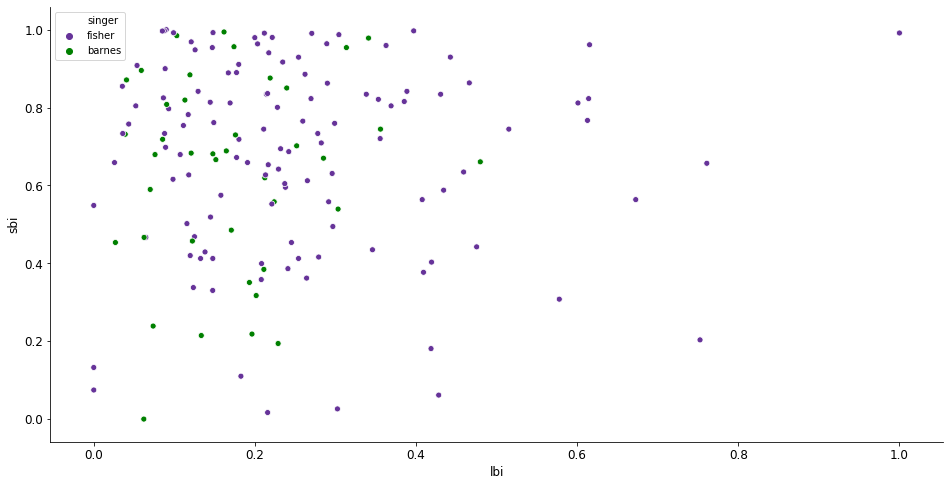

In [120]:
sns.scatterplot('lbi', 'sbi', hue='singer', data=song_data, palette=['rebeccapurple', 'green']);

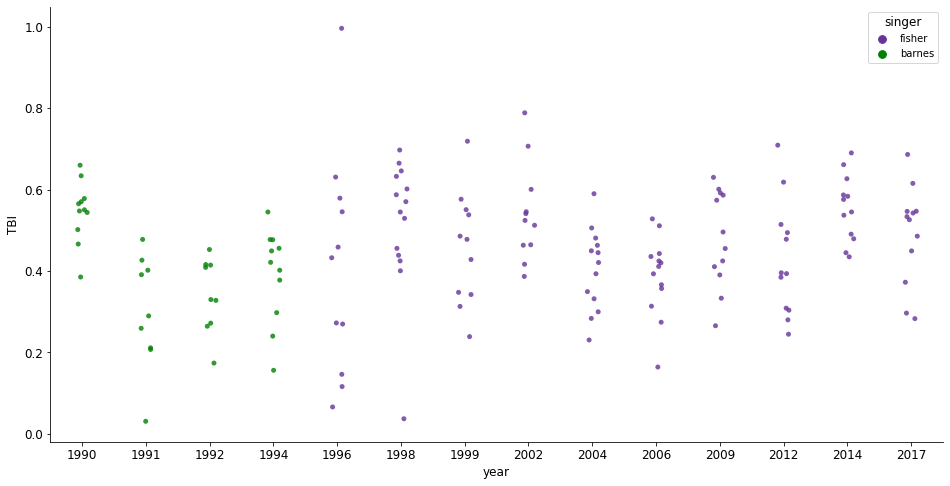

In [121]:
sns.stripplot('year', 'TBI', data=song_data, hue='singer', alpha=0.8, jitter=True, palette=['rebeccapurple', 'green']);

---

## For documentation only: Test Alternative LBI Definitions

This section was to understand if I would get different results with another definition of the lbi, working with mean wbi scores instead of brutal word count. - The results are quite similar. And as soon as the 'lyrical density' is taken into account,'Puncture Wound Massacre' comes out on top again. Only the next songs differ.

In [ ]:
def calculate_lb_features_2(text, wbi_treshold=wbi_threshold):
    """Calculate and return features needed to calculate the lbi."""
    total_words = len(text)
    wbi_mean = np.mean(text)
        
    return total_words, wbi_mean

In [ ]:
lb_features_dict2 = {title: calculate_lb_features_2(text) 
                    for title, text in lyrics_dict_wbi.items()}
print(list(lb_features_dict2.items())[:2])

In [ ]:
lyric_data2 = pd.DataFrame(lb_features_dict2.keys(), columns=['title'])
lyric_data2['total_words'] = lyric_data2['title'].apply(lambda x: lb_features_dict2[x][0])
lyric_data2['wbi_mean'] = lyric_data2['title'].apply(lambda x: lb_features_dict2[x][1])
display(lyric_data2.sort_values(['wbi_mean'], ascending=False).head())

These are the five top-scoring songs by mean_wbi only (the mean of all wbi_scores for the total of words in the song). It has some overlap with the brutal-word-count-top-list from above.

In [ ]:
song_data2 = pd.merge(audio_data, lyric_data2, on='title', how='inner')
song_data2.info()

In [ ]:
# Calculate the lyrical density
song_data2['l_density'] = song_data2['total_words'] / song_data2['duration_sec']
display(song_data2[['title', 'wbi_mean', 'l_density']].nlargest(5, 'l_density'))

In [ ]:
# Calculate the lbi - arithmetic mean
song_data2['lbi_a'] = (song_data2['wbi_mean'] + song_data2['l_density']) / 2
display(song_data2[['title', 'lbi_a']].nlargest(5, 'lbi_a'))

In [ ]:
# Calculate the lbi - geometric mean (out of curiosity - no difference, as expected)
song_data2['lbi_g'] = np.sqrt(song_data2['wbi_mean'] + song_data2['l_density'])
display(song_data2[['title', 'lbi_g']].nlargest(5, 'lbi_g'))

---